<a href="https://colab.research.google.com/github/taritro98/BERT_Adverse_News_analysis/blob/master/CMA1934_Data_Scientist_Technical_Test_Taritro_Ghoshal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMA SEO Data Scientist - technical test
Author - Taritro Ghoshal

## Preamble

#### Timings

You have until the agreed deadline to submit your response to this test. The test shouldn't take more than three hours to complete. You're free to organise your time as you wish between now and the agreed deadline. You can also submit early if you wish to do so. No additional credit will be given for very long responses and extra time spent.

#### Your code

Please return all outputs, including code, in whichever format you prefer. Feel free to use the provided jupyter notebook to complete all your answers - for both code and text responses.

Please ensure all code is in Python and that it runs without errors before submitting. As part of your response, please let us know which Python version you used as well as any other dependencies (i.e. Python packages) required to run your code.

#### Your writing

In all writing, please assume your audience has some, but not advanced, familiarity with technical and statistical concepts (e.g. an economist)

#### The assessment

You will be assessed on:

* your approach to the question and analytical reasoning given
* your understanding and implementation of data science techniques
* the quality of your code

There is no "right" answer to any of the questions. Many vastly different approaches to the problem could all gain full credit in the assessment.

Your performance in this test will determine whether you will be invited to the interview. If you’re invited, during the interview we will review your answers and discuss your approach to parts of the test.

## The test

The data science team at the CMA have received some complaints from consumers about the number of fake product reviews on a website that sells coffee tables. The complaints allege that coffee table sellers have been trying to mislead consumers by acquiring reviews on their products that do not represent a true customer experience, with the aim of boosting their sales. You have been provided with a dataset of reviews on this website containing the following fields in the `data.parquet` file:

* review_id: the primary key of the dataset, each row of the dataset represents an individual review with a unique identifier
* product_id: an identifier for the coffee table
* reviewer_id: an identifier for the user leaving the review
* review_rating: a score given to the product by the user, out of 5
* review_text: the full text of the review left by the user. This can be blank where the user left a rating only
* review_date: the date the review was posted. The dataset covers the full year to 31 December 2022.

The dataset can be loaded using:
```
import pandas as pd
data = pd.read_parquet("data.parquet")
```
(assuming the data.parquet file is in the same directory as the jupyter notebook)

## Question 1.

With consideration to the objective of identifying fake reviews, carry out a brief exploratory analysis on the dataset and identify some interesting features. Include a short explanation of any findings.

_Your answer:_

In [ ]:
## Install necessary libraries
!pip install -q contractions catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import contractions
import re
import string
from bs4 import BeautifulSoup
from sklearn.metrics.pairwise import cosine_distances

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import word_tokenize

from textblob import TextBlob
from wordcloud import WordCloud

from google.colab import drive
drive.mount('/content/drive')

<ipython-input-2-f0e4401348b6>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Load the datasets
df = pd.read_parquet('/content/drive/MyDrive/cma1934datascientisttechnicaltest/data.parquet')

In [ ]:
print("Shape of the dataframe ->", df.shape)

Shape of the dataframe -> (3244, 6)


In [ ]:
## Check for Null values
print(df.isnull().sum())

review_id           0
product_id          0
reviewer_id         0
review_rating       0
review_text      2951
review_date         0
dtype: int64


In [ ]:
## Check for duplicates
duplicate_cols = ["product_id","reviewer_id","review_rating","review_text"]
df[duplicate_cols][df[duplicate_cols].duplicated()]

,product_id,reviewer_id,review_rating,review_text


There are 2951 null values in the review_text column but no duplicates (overall). But, going forward we will find that there are quite a few duplicate reviews in our date

In [ ]:
## Number of unique values in each column
for column in df.columns:
  print(column, "->", df[column].nunique())

review_id -> 3244
product_id -> 26
reviewer_id -> 2793
review_rating -> 5
review_text -> 204
review_date -> 364


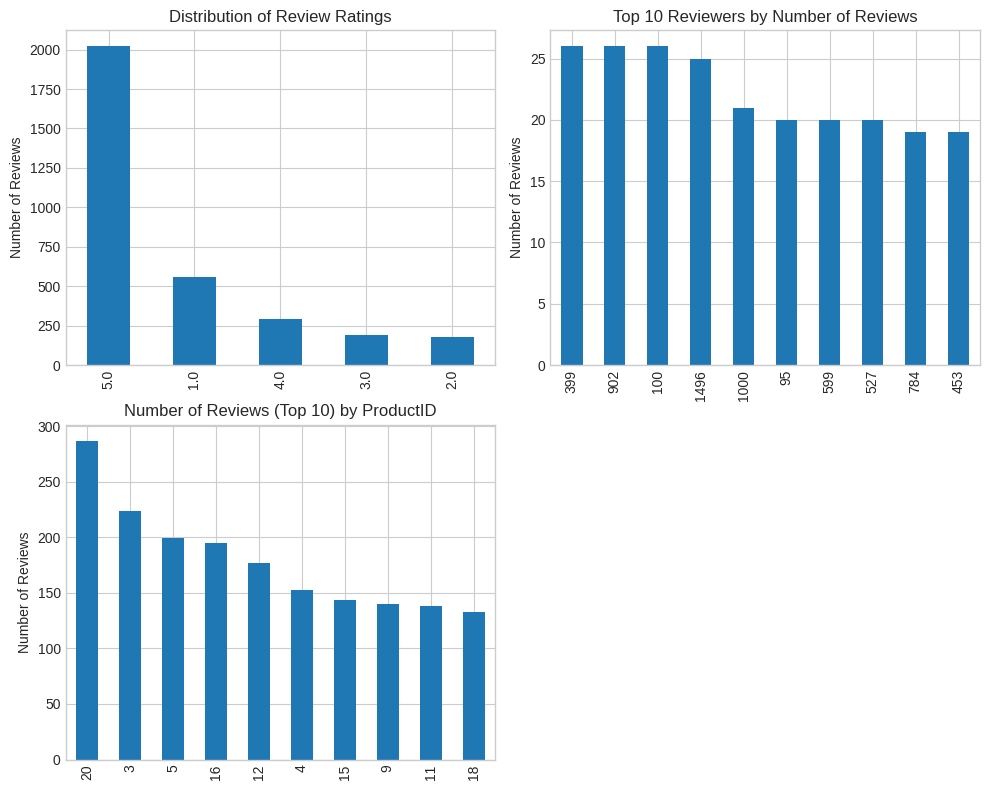

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10, 8))

# Plotting review_rating value counts
df['review_rating'].value_counts().plot(kind='bar', ax=axes[0,0], title="Distribution of Review Ratings")
axes[0,0].set_ylabel("Number of Reviews")

# Plotting reviewer_id value counts
df['reviewer_id'].value_counts()[:10].plot(kind='bar', ax=axes[0,1], title="Top 10 Reviewers by Number of Reviews")
axes[0,1].set_ylabel("Number of Reviews")

# Plotting product_id value counts
df['product_id'].value_counts()[:10].plot(kind='bar', ax=axes[1,0], title="Number of Reviews (Top 10) by ProductID")
axes[1,0].set_ylabel("Number of Reviews")
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

### Reviewer-Based Analysis

In [ ]:
len(df['product_id'].value_counts())

26

There are only 26 distinct products, reviewers having around near about 26 reviews are likely to be fake

In [ ]:
grouped_by_reviewer = df.groupby('reviewer_id').agg(
    number_of_reviews=pd.NamedAgg(column='review_id', aggfunc='size'),
    products_reviewed=pd.NamedAgg(column='product_id', aggfunc=lambda x: list(x.unique()))
).reset_index().sort_values(by='number_of_reviews', ascending=False)
grouped_by_reviewer.head(20)

,reviewer_id,number_of_reviews,products_reviewed
92,100,26,"[18, 4, 15, 6, 2, 13, 7, 20, 24, 14, 3, 23, 10..."
849,902,26,"[16, 13, 19, 2, 7, 17, 3, 11, 15, 6, 22, 4, 18..."
366,399,26,"[5, 25, 8, 7, 21, 3, 11, 12, 20, 16, 17, 6, 22..."
1398,1496,25,"[13, 4, 9, 17, 6, 22, 14, 16, 24, 2, 11, 1, 21..."
935,1000,21,"[16, 13, 5, 2, 10, 18, 21, 22, 3, 15, 1, 24, 1..."
88,95,20,"[26, 14, 18, 13, 17, 9, 24, 19, 1, 2, 4, 5, 8,..."
562,599,20,"[5, 18, 11, 22, 19, 8, 26, 16, 24, 1, 25, 4, 1..."
492,527,20,"[1, 24, 23, 16, 14, 12, 2, 3, 21, 7, 18, 22, 1..."
420,453,19,"[9, 18, 13, 2, 4, 6, 26, 24, 19, 17, 7, 14, 10..."
735,784,19,"[21, 14, 15, 5, 24, 3, 23, 13, 11, 25, 16, 22,..."


Here we can see that there are a lot of reviewers with more than 20 reviews, reaching even upto 26 reviews. These reviewers are likely to be either promoters or paid to post fake reviews. We'll go into a bit more detail below.

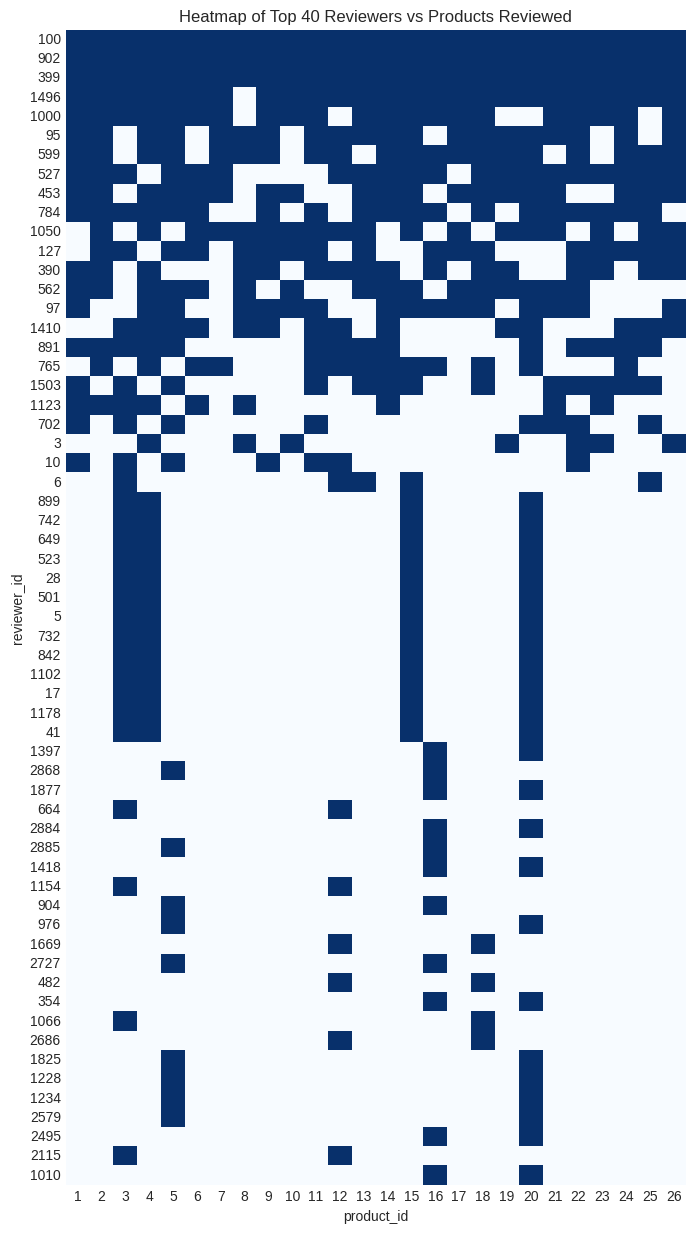

In [ ]:
fig, _ = plt.subplots(figsize=(8, 15))
matrix = df.pivot_table(index='reviewer_id', columns='product_id', values='review_rating', aggfunc='count')
top_reviewers = grouped_by_reviewer['reviewer_id'].head(60)
sns.heatmap(matrix.loc[top_reviewers].notna(), cmap="Blues", cbar=False)
plt.title('Heatmap of Top 40 Reviewers vs Products Reviewed')
plt.show()

Reviewers with reviewer id (100, 902, 399, 1496, 1000, 95, 599, 527, 453, 784, 1050, 127, 390) have rated more than 13 out of 26 products hence they are likely to be promoters or fake.

In [ ]:
top_reviewers_ids = grouped_by_reviewer[grouped_by_reviewer['number_of_reviews']>13]['reviewer_id'].tolist()
top_reviewers_filtered_df = df[df['reviewer_id'].isin(top_reviewers_ids)]

In [ ]:
# Products most often reviewed by top reviewers
product_review_counts = top_reviewers_filtered_df.groupby(['reviewer_id', 'product_id']).size().reset_index(name='count')
pivot_table = product_review_counts.pivot('reviewer_id', 'product_id', 'count').fillna(0)
# Analyze rating bias for top reviewers
rating_bias = top_reviewers_filtered_df.groupby('reviewer_id')['review_rating'].mean().reset_index()

<ipython-input-14-246d0cdb5045>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = product_review_counts.pivot('reviewer_id', 'product_id', 'count').fillna(0)


In [ ]:
product_review_counts[product_review_counts["count"]>1]

,reviewer_id,product_id,count


There are no reviewers with multiple reviews in a single product


In [ ]:
top_reviewers_filtered_df[top_reviewers_filtered_df['review_rating'] < 5]

,review_id,product_id,reviewer_id,review_rating,review_text,review_date


All top reviewers have never given a rating less than 5

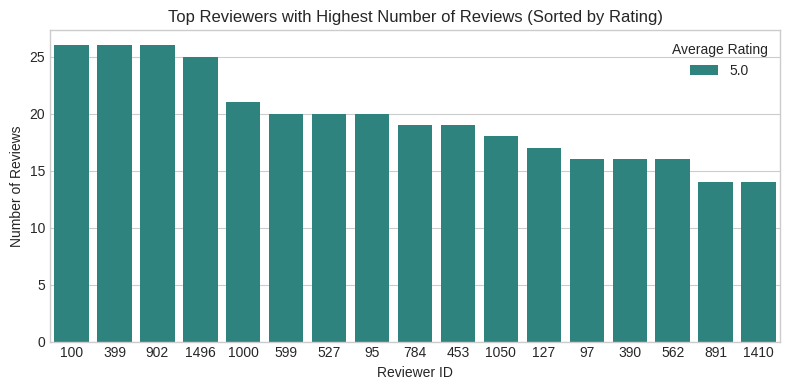

In [ ]:
# Sort the DataFrame by the number of reviews in descending order
# Filter for the top reviewers with highest rating means
top_reviewers_highest_rating = top_reviewers_filtered_df.groupby('reviewer_id').agg(
    number_of_reviews=pd.NamedAgg(column='review_id', aggfunc='size'),
    average_rating=pd.NamedAgg(column='review_rating', aggfunc='mean')
).nlargest(40, 'average_rating').sort_values(by='number_of_reviews', ascending=False)

fig, axes = plt.subplots(figsize=(8, 4))

# Create the bar graph
sns.barplot(data=top_reviewers_highest_rating, x=top_reviewers_highest_rating.index, y='number_of_reviews', hue='average_rating', palette='viridis', order=top_reviewers_highest_rating.index)
axes.set_title('Top Reviewers with Highest Number of Reviews (Sorted by Rating)')
axes.set_xlabel('Reviewer ID')
axes.set_ylabel('Number of Reviews')
axes.legend(title='Average Rating')

plt.tight_layout()
plt.show()

All of the top reviewers have given a rating of 5, which further attests of their likeliness to be fake reviewers

### Review Text-Based Analysis

In [ ]:
df['review_text'].isnull()

0        True
1        True
2       False
3        True
4        True
        ...  
3239     True
3240     True
3241     True
3242     True
3243     True
Name: review_text, Length: 3244, dtype: bool

In [ ]:
df_text = df[~df['review_text'].isnull()]
df_text

,review_id,product_id,reviewer_id,review_rating,review_text,review_date
2,3,18,1371,2.0,"2/5 Stars - Subpar. It feels flimsy and cheap,...",2022-01-01
14,15,1,2463,5.0,5/5 Stars - Fantastic.,2022-01-02
38,39,15,2134,5.0,5/5 Stars - Elegant and Functional: I am absol...,2022-01-05
43,44,13,2525,5.0,5/5 Stars - Wow! Modern elegance personified.,2022-01-06
74,75,3,157,5.0,5/5 Stars - Modern Minimalism: I love the mini...,2022-01-11
...,...,...,...,...,...,...
3171,3172,2,2920,1.0,"1/5 Stars - Total Letdown, what a disappointme...",2022-12-18
3187,3188,3,2611,5.0,5/5 Stars - Modern Minimalism: I love the mini...,2022-12-21
3193,3194,21,1376,5.0,5/5 Stars - I adore the simplicity of this pot...,2022-12-22
3195,3196,21,2951,3.0,3/5 Stars - Average Quality: The pot's appeara...,2022-12-23


Only 293 out of 3244 reviews which have a review text

#### Text Preprocessing

In [ ]:
def expand_contractions(text):
    text = text.replace("’", "'").replace("‘", "'")
    text = text.replace("”", '"').replace("“", '"')
    return contractions.fix(text)

email_pattern = re.compile(r'\S+@\S+')
hashtags_pattern = re.compile(r'\#\w+')

# Remove HTML tags
df_text['proc_review_text'] = df_text['review_text'].apply(lambda x: BeautifulSoup(x,'lxml').get_text(" ", strip=True))
# Remove URLs
df_text['proc_review_text'] =  df_text['proc_review_text'] .apply(lambda x: re.sub(r'http\S+',' ', str(x)))
# Remove underscore
df_text['proc_review_text'] =  df_text['proc_review_text'] .apply(lambda x: re.sub(r'_',' ',str(x)))
# Expand contractions
df_text['proc_review_text'] = df_text['proc_review_text'] .apply(expand_contractions)
# Remove non-ascii
df_text['proc_review_text'] = df_text['proc_review_text'] .apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
# Remove emails
df_text['proc_review_text'] = df_text['proc_review_text'] .apply(lambda x: email_pattern.sub('', x))
# Remove hashtags
df_text['proc_review_text'] = df_text['proc_review_text'] .apply(lambda x: hashtags_pattern.sub('', x))
# Remove ampersand
df_text['proc_review_text'] = df_text['proc_review_text'] .replace('&amp;', '', regex=True)
# Remove brackets
df_text['proc_review_text'] = df_text['proc_review_text'] .str.replace(r'[\(\)\[\]\{\}]', ' ',regex=True)
# Remove punctuation
df_text['proc_review_text'] = df_text['proc_review_text'] .apply(lambda x:x.translate(str.maketrans("", "", string.punctuation+'”‘’“')))
# Remove extra spaces
df_text['proc_review_text'] = df_text['proc_review_text'] .replace('\s+', ' ', regex=True)
# Convert string to lowercase
df_text['proc_review_text'] = df_text['proc_review_text'] .str.lower()

In [ ]:
## Remove stopwords using gensim
df_text['proc_review_text'] =  df_text['proc_review_text'].apply(lambda x: remove_stopwords(x))

def tokenize_lemmatize_text(text):
    tokenized_sent = word_tokenize(text)
    return " ".join([wordnet_lemmatizer.lemmatize(word) for word in tokenized_sent])

wordnet_lemmatizer = WordNetLemmatizer()
df_text['proc_review_text'] =  df_text['proc_review_text'].apply(lambda x: tokenize_lemmatize_text(x))

In [ ]:
pd.set_option('display.max_colwidth', None)
df_text[["review_text","proc_review_text"]]

,review_text,proc_review_text
2,"2/5 Stars - Subpar. It feels flimsy and cheap, plus the assembly instructions were incredibly confusing. Not recommended.**",25 star subpar feel flimsy cheap plus assembly instruction incredibly confusing recommended
14,5/5 Stars - Fantastic.,55 star fantastic
38,"5/5 Stars - Elegant and Functional: I am absolutely in love with my new coffee table! The sleek design adds a touch of elegance to my living room, and the ample storage space underneath is a game-changer. It's sturdy and well-crafted too. Highly recommended!",55 star elegant functional absolutely love new coffee table sleek design add touch elegance living room ample storage space underneath gamechanger sturdy wellcrafted highly recommended
43,5/5 Stars - Wow! Modern elegance personified.,55 star wow modern elegance personified
74,"5/5 Stars - Modern Minimalism: I love the minimalist design of this coffee table. It's simple yet striking, and the metal accents add a contemporary touch. The quality is top-notch, and it was a breeze to put together. This table has transformed my living room into a stylish haven.",55 star modern minimalism love minimalist design coffee table simple striking metal accent add contemporary touch quality topnotch breeze table transformed living room stylish haven
...,...,...
3171,"1/5 Stars - Total Letdown, what a disappointment. This coffee table arrived damaged and missing parts. Customer service was unhelpful, and the quality was horrendous. Steer clear of this disaster",15 star total letdown disappointment coffee table arrived damaged missing part customer service unhelpful quality horrendous steer clear disaster
3187,"5/5 Stars - Modern Minimalism: I love the minimalist design of this coffee table. It's simple yet striking, and the metal accents add a contemporary touch. The quality is top-notch, and it was a breeze to put together. This table has transformed my living room into a stylish haven.",55 star modern minimalism love minimalist design coffee table simple striking metal accent add contemporary touch quality topnotch breeze table transformed living room stylish haven
3193,"5/5 Stars - I adore the simplicity of this pot. It lets my plants take the spotlight while adding a touch of sophistication. The size options are versatile, and the ceramic material feels premium.",55 star adore simplicity pot let plant spotlight adding touch sophistication size option versatile ceramic material feel premium
3195,"3/5 Stars - Average Quality: The pot's appearance is nice, but the quality is just okay. It feels a bit flimsy, and I'm unsure about its durability over time. It serves its purpose, but I expected better for the price.",35 star average quality pot appearance nice quality okay feel bit flimsy unsure durability time serf purpose expected better price


In [ ]:
df_text["no_of_words"] = df_text["proc_review_text"].apply(lambda x: len(x.split()))

In [ ]:
df_text[df_text['proc_review_text'].duplicated()]["proc_review_text"]

121     55 star modern minimalism love minimalist design coffee table simple striking metal accent add contemporary touch quality topnotch breeze table transformed living room stylish haven
163     55 star modern minimalism love minimalist design coffee table simple striking metal accent add contemporary touch quality topnotch breeze table transformed living room stylish haven
245                                                                                     55 star rustic beauty charming rustic table fit perfectly solid wood unique finish highly recommended
274     55 star modern minimalism love minimalist design coffee table simple striking metal accent add contemporary touch quality topnotch breeze table transformed living room stylish haven
313                                                                                                                                                           55 star bset coffee table world
                                                  

There are 90 reviews which are duplicates and hence fake

In [ ]:
df_text["polarity"] = df_text["proc_review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
possibly_spam_df = df_text[(abs(df_text['polarity']) < 0.4) & (df_text['no_of_words'] < 5)][['reviewer_id','proc_review_text']]
possibly_spam_df.head()

<ipython-input-30-d0e2871480ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["polarity"] = df_text["proc_review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)


,reviewer_id,proc_review_text
109,2191,55 star exceeded expectation
549,1564,25 star fell short
1015,1846,55 star wow
1044,655,55 star stellar
1203,2902,55 star aweinspiring


Shorter texts with neutral polarity are more likely to be spam/fake as shown in the above dataframe

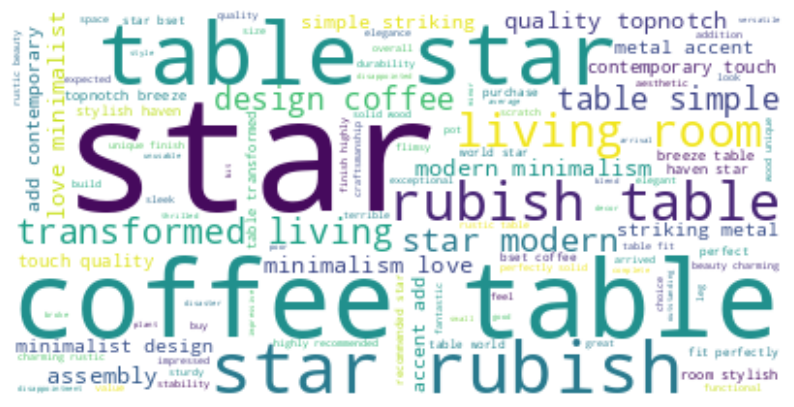

In [ ]:
text = ' '.join(df_text['proc_review_text'])

# Create a WordCloud object
wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(text)

# Visualize the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In the wordcloud for the overall dataset, we can identify that the most talked about topics are coffee tables, followed by some adverse reviews about the tables being rubbish possibly.

In [ ]:
grouped_by_reviewer_text = df_text.groupby('reviewer_id').agg(
    number_of_reviews=pd.NamedAgg(column='review_id', aggfunc='size'),
    products_reviewed=pd.NamedAgg(column='product_id', aggfunc=lambda x: list(x.unique()))
).reset_index().sort_values(by='number_of_reviews', ascending=False)
grouped_by_reviewer_text.head(20)

,reviewer_id,number_of_reviews,products_reviewed
0,23,1,[25]
184,2064,1,[10]
200,2186,1,[11]
199,2178,1,[5]
198,2162,1,[3]
197,2151,1,[5]
196,2146,1,[21]
195,2138,1,[5]
194,2134,1,[15]
193,2127,1,[23]


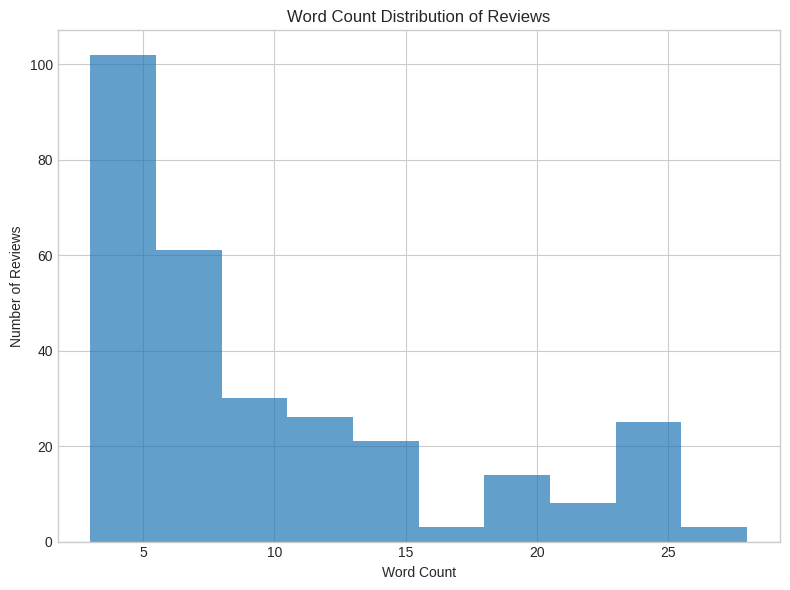

In [ ]:
fig, axes = plt.subplots(figsize=(8, 6))
# Plotting the word count distribution
plt.hist(df_text['no_of_words'], alpha=0.7)
plt.title('Word Count Distribution of Reviews')
plt.xlabel('Word Count')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

We can see that a majority of the reviews are short text with less than 10 words in length.

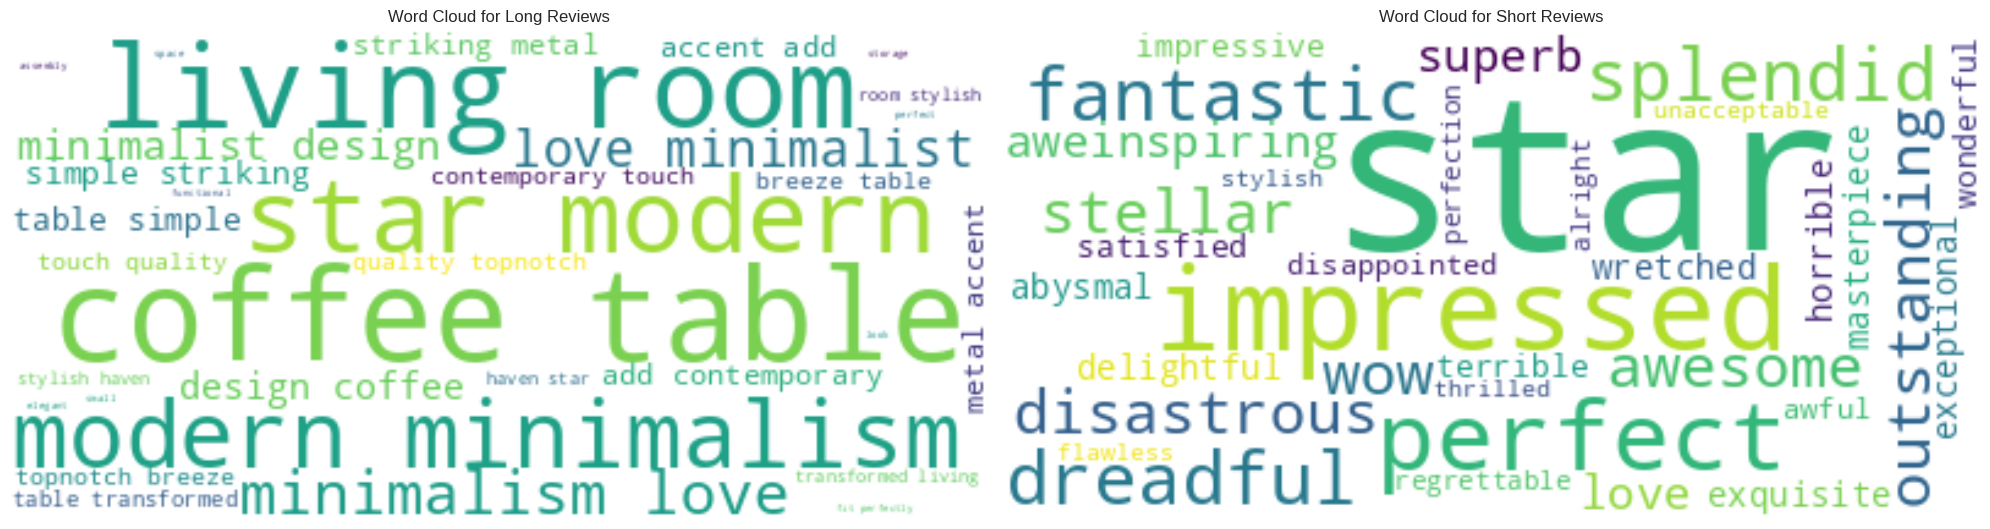

In [ ]:
# Define thresholds
long_threshold = df_text['no_of_words'].quantile(0.90)
short_threshold = df_text['no_of_words'].quantile(0.20)

# Extract long and short texts
long_texts = ' '.join(df_text[df_text['no_of_words'] > long_threshold]['proc_review_text'])
short_texts = ' '.join(df_text[df_text['no_of_words'] < short_threshold]['proc_review_text'])

# WordCloud for long reviews
wordcloud_long = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue').generate(long_texts)

# WordCloud for short reviews
wordcloud_short = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue').generate(short_texts)

# Set up subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plotting the word cloud for long reviews on the first subplot
ax[0].imshow(wordcloud_long, interpolation='bilinear')
ax[0].set_title("Word Cloud for Long Reviews")
ax[0].axis('off')

# Plotting the word cloud for short reviews on the second subplot
ax[1].imshow(wordcloud_short, interpolation='bilinear')
ax[1].set_title("Word Cloud for Short Reviews")
ax[1].axis('off')

plt.tight_layout()
plt.show()

We can witness a higher occurrence of words such as perfect, impressed, fantastic in short text reviews (as shown in the visualization on the right). Such 1 word reviews with neutral polarity can potentially be fake and should be investigated further.

### Time-Based Review Analysis

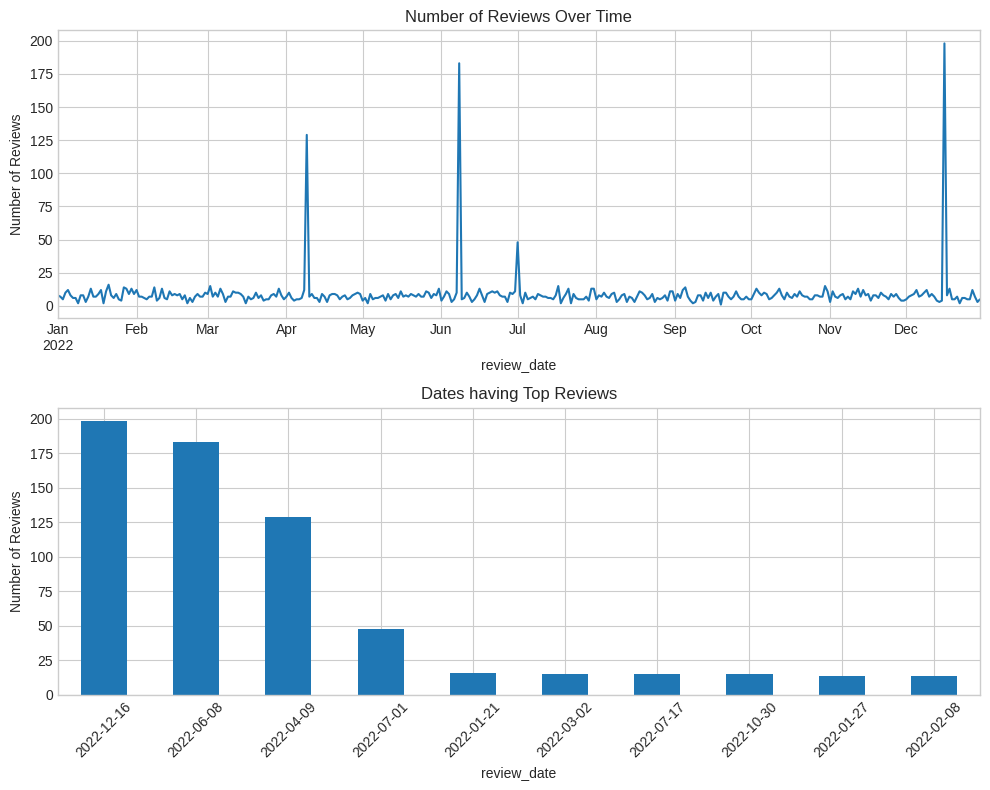

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Number of Reviews over Time
df.groupby('review_date').size().plot(title="Number of Reviews Over Time", ax=axes[0])
axes[0].set_ylabel("Number of Reviews")

# Dates having Top Reviews
top_dates = df.groupby('review_date').size().nlargest(10)
top_dates.index = top_dates.index.strftime('%Y-%m-%d')
top_dates.plot(kind='bar', ax=axes[1], title="Dates having Top Reviews")
axes[1].set_xticklabels(top_dates.index, rotation=45)
axes[1].set_ylabel("Number of Reviews")

plt.tight_layout()
plt.show()

Here we can notice that there are a few spike in reviews in the months of April, June and December. In the next visualization, we can see that there is a massive increase in the number of reviews on the particular dates of 16-12, 08-06 and 09-04. This warrants further investigation, but it is quite likely that there is some fake review system launching on these dates

In [ ]:
threshold_slider = widgets.IntSlider(value=3, min=1, max=30, step=1, description='Threshold (days):')

def plot_reviewers_with_short_time_spans(threshold):
    # Calculate the time span (in days) between consecutive reviews for each reviewer
    df['time_span'] = df.groupby('reviewer_id')['review_date'].diff().dt.days

    # Filter reviewers who have given multiple reviews during short time spans
    reviewers_with_short_time_spans = df[df['time_span'] < threshold].groupby('reviewer_id').size().sort_values(ascending=False)

    # Plot the number of reviews by these reviewers
    plt.figure(figsize=(12, 6))
    reviewers_with_short_time_spans.plot(kind='bar', title='Reviewers with Multiple Reviews in Short Time Spans')
    plt.xlabel('Reviewer ID')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Connect the slider to the function
widgets.interactive(plot_reviewers_with_short_time_spans, threshold=threshold_slider)

interactive(children=(IntSlider(value=3, description='Threshold (days):', max=30, min=1), Output()), _dom_clas…

In the above dynamic visualization, we can see that the reviewers 100, 902, 399, who have been previously flagged as well as being suspects of fake reviewers, post a very high number of reviews in a short time span. This confirms their likelihood of being fake reviewers.
The above visualization has been made dynamic using threshold sliders for better analysis.

In [ ]:
min_date = df['review_date'].min()
max_date = df['review_date'].max()

print(f"Date range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")

Date range: 2022-01-01 to 2022-12-30


## Question 2.

In no more than 500 words, explain how you might develop a system to identify potentially fake reviews in this dataset.

You could consider rule-based methods as well as both supervised and unsupervised machine learning techniques as part of your answer.

_Your answer:_

To tackle the issue of potentially fake reviews for coffee tables on the website, I would adopt a multi-faceted approach incorporating both rule-based methods and machine learning techniques. Given the challenge at hand, a combination of these methods is essential for a comprehensive solution.

**1. Data Preprocessing:**
Firstly, I would clean the review texts to prepare them for further analysis. My preprocessing steps would include:
- Stripping away HTML tags, URLs, emails, and other non-essential patterns.
- Expanding contractions to normalize words to their full forms.
- Removing non-ascii characters, punctuations, and converting all text to lowercase.
- Applying tokenization and lemmatization to decompose the text into meaningful base words. This enhances the relevance and consistency of the text for subsequent analysis.

**2. Supervised Machine Learning:**
I would utilize a labeled dataset with reviews categorized as fake or genuine (as provided in `fake_reviews_dataset.csv`). After preprocessing this data:
- I would divide it into training and validation sets.
- I'd employ TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to numerically represent the review texts.
- Using the transformed data, I would then train a CatBoost classifier. CatBoost is adept at handling categorical data and generally offers good performance with minimal overfitting risk.
- With a trained model in place, I would be equipped to predict whether a particular review seems potentially fake or genuine.

**3. Unsupervised Machine Learning (KMeans Clustering):**
Recognizing that supervised methods might not catch all fake reviews, I would also incorporate an unsupervised technique as another layer of analysis.
- By focusing on features like `product_id`, `reviewer_id`, and `review_rating`,
- I'd deploy KMeans clustering to group reviews into various clusters.
- Inspecting patterns in these clusters, such as:
  - Cluster sizes
  - Distribution of review ratings
  - Behavior patterns of individual reviewers

I could highlight unusual or suspicious activities. For instance, clusters dominated by perfect ratings or a reviewer giving multiple reviews in quick succession could be red flags.

**Rule-based methods:**
In addition to the machine learning strategies, I would also introduce heuristic rule-based methods:
- **Temporal Patterns:** Observing for any unusual spikes in review submissions which could indicate coordinated fake reviews.
- **Extreme Ratings without Text:** Solely 1-star or 5-star ratings without any review text could be potential indicators of non-genuine reviews.
- **Review Patterns:** If a user is submitting a suspiciously high number of reviews in quick succession, they would be flagged.
- **Polarity and Word Length:** As implemented in my analysis above, I'd employ a heuristic based on the polarity of the review and its word length. Short reviews with extreme positive or negative sentiments could be indicative of potential fake reviews.

**Conclusion:**
To devise an effective system to identify fake reviews, I'd ensure a harmonious blend of various techniques. While supervised methods provide precision through learning from labeled data, unsupervised techniques can uncover hidden patterns. By coupling these with rule-based strategies, I'd aim to achieve a multi-layered and robust approach to discerning the authenticity of reviews. Regular refinements would be essential to keep the system current and effective against evolving fake review strategies.



## Question 3.

Implement one of the methods you have suggested in Question 2 using the dataset. Please provide a brief written explanation of the pros and cons of this method, based on the results you get.

_Your answer:_

### Loading External Dataset and Preprocessing

In [ ]:
# Dataset Source - https://raw.githubusercontent.com/SayamAlt/Fake-Reviews-Detection/main/fake%20reviews%20dataset.csv
# License -  CC-By Attribution 4.0 International
fakerev_df = pd.read_csv("/content/drive/MyDrive/cma1934datascientisttechnicaltest/fake_reviews_dataset.csv", usecols=["rating", "text_","label"])
fakerev_df = fakerev_df.head(10000)
fakerev_df.head()

,rating,label,text_
0,5.0,CG,"Love this! Well made, sturdy, and very comfortable. I love it!Very pretty"
1,5.0,CG,"love it, a great upgrade from the original. I've had mine for a couple of years"
2,5.0,CG,This pillow saved my back. I love the look and feel of this pillow.
3,1.0,CG,"Missing information on how to use it, but it is a great product for the price! I"
4,5.0,CG,Very nice set. Good quality. We have had the set for two months now and have not been


In [ ]:
fakerev_df['label'] = fakerev_df['label'].replace({"OR": 0, "CG": 1})

In [ ]:
fakerev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  10000 non-null  float64
 1   label   10000 non-null  int64  
 2   text_   10000 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [ ]:
def expand_contractions(text):
    text = text.replace("’", "'").replace("‘", "'")
    text = text.replace("”", '"').replace("“", '"')
    return contractions.fix(text)

email_pattern = re.compile(r'\S+@\S+')
hashtags_pattern = re.compile(r'\#\w+')

# Remove HTML tags
fakerev_df['proc_review_text'] = fakerev_df['text_'].apply(lambda x: BeautifulSoup(x,'lxml').get_text(" ", strip=True))
# Remove URLs
fakerev_df['proc_review_text'] =  fakerev_df['proc_review_text'] .apply(lambda x: re.sub(r'http\S+',' ', str(x)))
# Remove underscore
fakerev_df['proc_review_text'] =  fakerev_df['proc_review_text'] .apply(lambda x: re.sub(r'_',' ',str(x)))
# Expand contractions
fakerev_df['proc_review_text'] = fakerev_df['proc_review_text'] .apply(expand_contractions)
# Remove non-ascii
fakerev_df['proc_review_text'] = fakerev_df['proc_review_text'] .apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
# Remove emails
fakerev_df['proc_review_text'] = fakerev_df['proc_review_text'] .apply(lambda x: email_pattern.sub('', x))
# Remove hashtags
fakerev_df['proc_review_text'] = fakerev_df['proc_review_text'] .apply(lambda x: hashtags_pattern.sub('', x))
# Remove ampersand
fakerev_df['proc_review_text'] = fakerev_df['proc_review_text'] .replace('&amp;', '', regex=True)
# Remove brackets
fakerev_df['proc_review_text'] = fakerev_df['proc_review_text'] .str.replace(r'[\(\)\[\]\{\}]', ' ',regex=True)
# Remove punctuation
fakerev_df['proc_review_text'] = fakerev_df['proc_review_text'] .apply(lambda x:x.translate(str.maketrans("", "", string.punctuation+'”‘’“')))
# Remove extra spaces
fakerev_df['proc_review_text'] = fakerev_df['proc_review_text'] .replace('\s+', ' ', regex=True)
# Convert string to lowercase
fakerev_df['proc_review_text'] = fakerev_df['proc_review_text'] .str.lower()

## Remove stopwords using gensim
fakerev_df['proc_review_text'] =  fakerev_df['proc_review_text'].apply(lambda x: remove_stopwords(x))

def tokenize_lemmatize_text(text):
    tokenized_sent = word_tokenize(text)
    return " ".join([wordnet_lemmatizer.lemmatize(word) for word in tokenized_sent])

wordnet_lemmatizer = WordNetLemmatizer()
fakerev_df['proc_review_text'] =  fakerev_df['proc_review_text'].apply(lambda x: tokenize_lemmatize_text(x))

<ipython-input-41-7d2f333ede63>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  fakerev_df['proc_review_text'] = fakerev_df['text_'].apply(lambda x: BeautifulSoup(x,'lxml').get_text(" ", strip=True))


In [ ]:
fakerev_df

,rating,label,text_,proc_review_text
0,5.0,1,"Love this! Well made, sturdy, and very comfortable. I love it!Very pretty",love sturdy comfortable love itvery pretty
1,5.0,1,"love it, a great upgrade from the original. I've had mine for a couple of years",love great upgrade original couple year
2,5.0,1,This pillow saved my back. I love the look and feel of this pillow.,pillow saved love look feel pillow
3,1.0,1,"Missing information on how to use it, but it is a great product for the price! I",missing information use great product price
4,5.0,1,Very nice set. Good quality. We have had the set for two months now and have not been,nice set good quality set month
...,...,...,...,...
9995,5.0,0,Excellent power strip that meets many needs.\nSpecifically:\nWide spacing between plugs with two extra wide transformer receptacle.\nVariety of USB power ports (2 ports for 2.4 A; 1 port for 1 A; and a auto regulating 0-2.4 A)\nSix foot cable is a convenient length for a power strip.,excellent power strip meet need specifically wide spacing plug extra wide transformer receptacle variety usb power port 2 port 24 1 port 1 auto regulating 024 foot cable convenient length power strip
9996,4.0,0,I bought this as my 'training' strobe. It works pretty good for portraits and product pictures.\nThe only minus is that you only get full and half setting but it is easily overcome by moving the strobe or reducing exposure in camera (F-stop or shutter speed),bought training strobe work pretty good portrait product picture minus half setting easily overcome moving strobe reducing exposure camera fstop shutter speed
9997,5.0,0,"This subwoofer was purchased as an additional unit for a small 2.1 home theater setup. Used primarily to play bass-heavy music, this subwoofer absolutely keeps up with loud environments, and, coming from a pro sound background, is one of the best consumer subwoofers Ive personally heard.",subwoofer purchased additional unit small 21 home theater setup primarily play bassheavy music subwoofer absolutely keep loud environment coming pro sound background best consumer subwoofer personally heard
9998,4.0,0,"Works as described with a Samsung Galaxy S3 but as long as you plug into a wall charger. Used it on a now 52"" legacy Sony XBR LCD TV & a new Pioneer LED LCD monitor TV at work via one of its HDMI inputs.",work described samsung galaxy s3 long plug wall charger 52 legacy sony xbr lcd tv new pioneer led lcd monitor tv work hdmi input


### Supervised Learning - Catboost Classifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
df_train, df_val = train_test_split(fakerev_df, test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on the training data and transform the texts
X_train_tfidf = tfidf.fit_transform(df_train['proc_review_text']).toarray()
X_val_tfidf = tfidf.transform(df_val['proc_review_text']).toarray()

y_train = df_train['label']
y_val = df_val['label']

# Initialize CatBoost Classifier
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, verbose=200)

In [ ]:
# Train CatBoost Classifier
catboost_model.fit(X_train_tfidf, y_train)

0:	learn: 0.6868472	total: 444ms	remaining: 7m 23s
200:	learn: 0.4333259	total: 35.4s	remaining: 2m 20s
400:	learn: 0.3457579	total: 1m 8s	remaining: 1m 41s
600:	learn: 0.2955592	total: 1m 44s	remaining: 1m 9s
800:	learn: 0.2630776	total: 2m 25s	remaining: 36.1s
999:	learn: 0.2394994	total: 2m 59s	remaining: 0us


In [ ]:
# Predict on the validation data
y_pred = catboost_model.predict(X_val_tfidf)

# Print classification report
print(classification_report(y_val, y_pred))

# Print accuracy
print("Accuracy:", accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       992
           1       0.86      0.81      0.83      1008

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

Accuracy: 0.837


In [ ]:
X_test_tfidf = tfidf.transform(df_text['proc_review_text']).toarray()
y_test = catboost_model.predict(X_test_tfidf)

In [ ]:
predictions_df = pd.concat([df_text.reset_index(drop=True),pd.DataFrame({'predictions': y_test})], axis=1)
predictions_df[predictions_df["predictions"] == 1.0]

,review_id,product_id,reviewer_id,review_rating,review_text,review_date,proc_review_text,no_of_words,review_len,polarity,predictions
37,439,7,2795,5.0,5/5 Stars - Stylish and Practical: I'm thrilled with my purchase. The sleek lines and modern finish of this coffee table blend seamlessly with my decor. The hidden compartments are a genius addition for decluttering. A fantastic find!,2022-02-25,55 star stylish practical thrilled purchase sleek line modern finish coffee table blend seamlessly decor hidden compartment genius addition decluttering fantastic,21,162,0.272222,1
44,495,10,1636,5.0,5/5 Stars - Quality shines. Solid and stylish design.,2022-03-03,55 star quality shine solid stylish design,7,42,0.250000,1
61,679,12,1109,3.0,"3/5 Stars - Nice Design, Average Build: The coffee table looks fantastic, and I'm a fan of the design. However, I did notice that the build quality isn't as solid as I had hoped. The wood seems a bit thin, and there's a slight wobble. It's functional, but I expected a bit more durability.",2022-03-28,35 star nice design average build coffee table look fantastic fan design notice build quality solid hoped wood bit slight wobble functional expected bit durability,25,163,0.097222,1
85,1064,15,2875,5.0,"5/5 Stars - Beautiful addition. Great quality, modern appeal.",2022-05-05,55 star beautiful addition great quality modern appeal,8,54,0.616667,1
104,1207,4,2106,5.0,5/5 Stars - Amazing addition. Completes my room beautifully.,2022-05-24,55 star amazing addition completes room beautifully,7,51,0.725000,1


Following a supervised learning method, a CatBoost model was meticulously trained on an external dataset specifically curated for fake reviews. By harnessing this external dataset, the model already has insights derived from patterns of known fake reviews, giving it an edge when analyzing a new, unseen dataset.

Employing a pre-trained model, especially from a dataset tailored for fake reviews, is instrumental in bolstering the performance of our system. This method offers several advantages:

- Transfer Learning: Leveraging knowledge from one dataset (in this case, the external fake reviews dataset) to improve performance on a different, but related dataset allows the model to generalize better and quicker.
- Enhanced Robustness: A model trained on diverse examples can detect a broader array of deceptive tactics used in fake reviews.
- Efficiency: Instead of starting the learning process from scratch, the model already possesses foundational knowledge, thereby reducing the time and resources required to train and refine it further.

### Unsupervised Learning - KMeans Clustering

In [ ]:
df_unsup = df[["product_id","reviewer_id","review_rating","review_date"]]
df_unsup['month'] = df_unsup['review_date'].dt.month
df_unsup['day'] = df_unsup['review_date'].dt.day
df_unsup = df_unsup.drop("review_date", axis=1)

<ipython-input-74-2399d262020d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unsup['month'] = df_unsup['review_date'].dt.month
<ipython-input-74-2399d262020d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unsup['day'] = df_unsup['review_date'].dt.day


In [ ]:
df_unsup

,product_id,reviewer_id,review_rating,month,day
0,6,529,5.0,1,1
1,11,97,5.0,1,1
2,18,1371,2.0,1,1
3,5,399,5.0,1,1
4,15,1214,2.0,1,1
...,...,...,...,...,...
3239,17,2922,5.0,12,30
3240,19,1510,5.0,12,30
3241,4,2994,1.0,12,30
3242,2,2597,4.0,12,30


In [ ]:
# Initialize number of clusters and iterations
num_clusters = 5
niter = 50

# Choose random centroids from the dataframe rows
idx = np.random.choice(len(df_unsup), num_clusters, replace=False)
old_centroids = df_unsup.values[idx, :]

# Calculate initial distances and assign to clusters
distances = cosine_distances(df_unsup.values, old_centroids)
cluster_pts = np.array([np.argmin(i) for i in distances])

# Start the KMeans iterations
np.random.seed(5)
for iteration in range(niter):
    new_centroids = []

    # Calculate new centroids
    for idx in range(num_clusters):
        temp_cent = df_unsup.values[cluster_pts == idx].mean(axis=0)
        new_centroids.append(temp_cent)

    new_centroids = np.vstack(new_centroids)

    # Calculate the centroid shift
    centroid_dist = np.linalg.norm(new_centroids - old_centroids, 2)
    print("Centroid dist", centroid_dist)

    # Check for convergence
    if centroid_dist <= 0.001:
        print(f"Stopping at number of iterations - {iteration}")
        break

    old_centroids = new_centroids

    # Assign to the new clusters
    distances = cosine_distances(df_unsup.values, new_centroids)
    cluster_pts = np.array([np.argmin(i) for i in distances])

Centroid dist 1150.1658654451871
Centroid dist 348.43947909012263
Centroid dist 286.6124880114454
Centroid dist 285.0232217389942
Centroid dist 291.11222229523844
Centroid dist 256.7007317742479
Centroid dist 230.4196397559894
Centroid dist 164.6350838691738
Centroid dist 118.59442311547141
Centroid dist 127.61175172699204
Centroid dist 133.8702004828878
Centroid dist 155.2761931008257
Centroid dist 137.14593554346553
Centroid dist 84.19201807469793
Centroid dist 69.97165752595272
Centroid dist 63.72414710807151
Centroid dist 56.68799461666034
Centroid dist 59.48666192128877
Centroid dist 48.004352560598214
Centroid dist 46.86526449388006
Centroid dist 39.11541889726619
Centroid dist 34.474986227193405
Centroid dist 32.33404866648044
Centroid dist 30.119665974230124
Centroid dist 30.05235498302649
Centroid dist 29.069572832778004
Centroid dist 34.171398077858704
Centroid dist 23.813506174081127
Centroid dist 21.25228836375017
Centroid dist 16.05904426814234
Centroid dist 11.26462217726

In the above code, a custom KMeans clustering method with cosine distances is being used. The centroids of clusters are re-calculated in each iteration until they converge (minimal change between iterations). It took 41 iterations for the centroids to converge based on the stopping criterion of centroid distance. Once the clustering is complete, data points are labeled with their respective clusters.

In [ ]:
df_unsup['cluster'] = cluster_pts

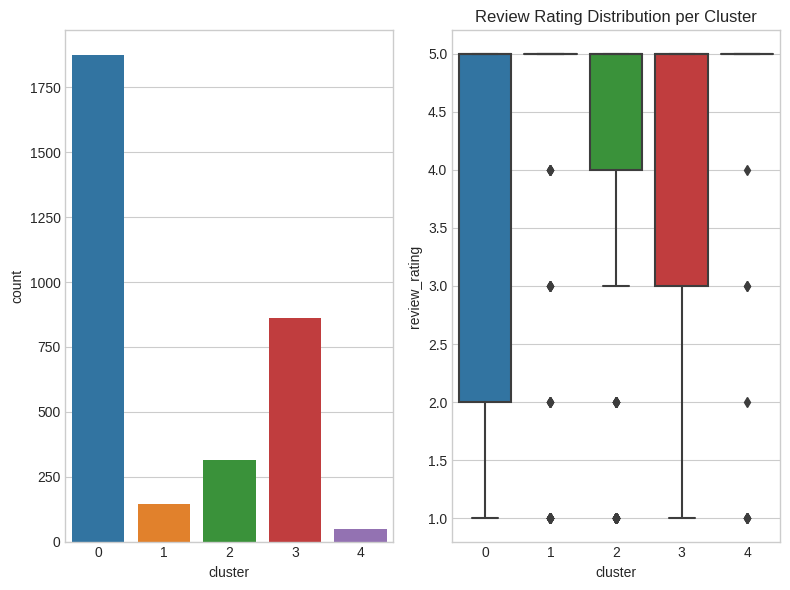

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8, 6))
# Cluster Sizes
sns.countplot(x='cluster', data=df_unsup, ax=axes[0])
plt.title('Cluster Sizes')

# Review Rating Distribution per Cluster
sns.boxplot(x='cluster', y='review_rating', data=df_unsup, ax=axes[1])
plt.title('Review Rating Distribution per Cluster')

plt.tight_layout()
plt.show()

The first set of graphs gives an idea of the distribution of data points across different clusters and the review ratings per cluster.

1. Cluster Sizes: Cluster 0 is the largest, followed by Cluster 1. Cluster 2, 3, and 4 are significantly smaller in comparison.
2. Review Rating Distribution: Cluster 0 has a very high review rating, around 4.5, Cluster 1 and 3 have moderate ratings, Cluster 2 has the highest variance in review ratings, and Cluster 4 has the lowest average rating.

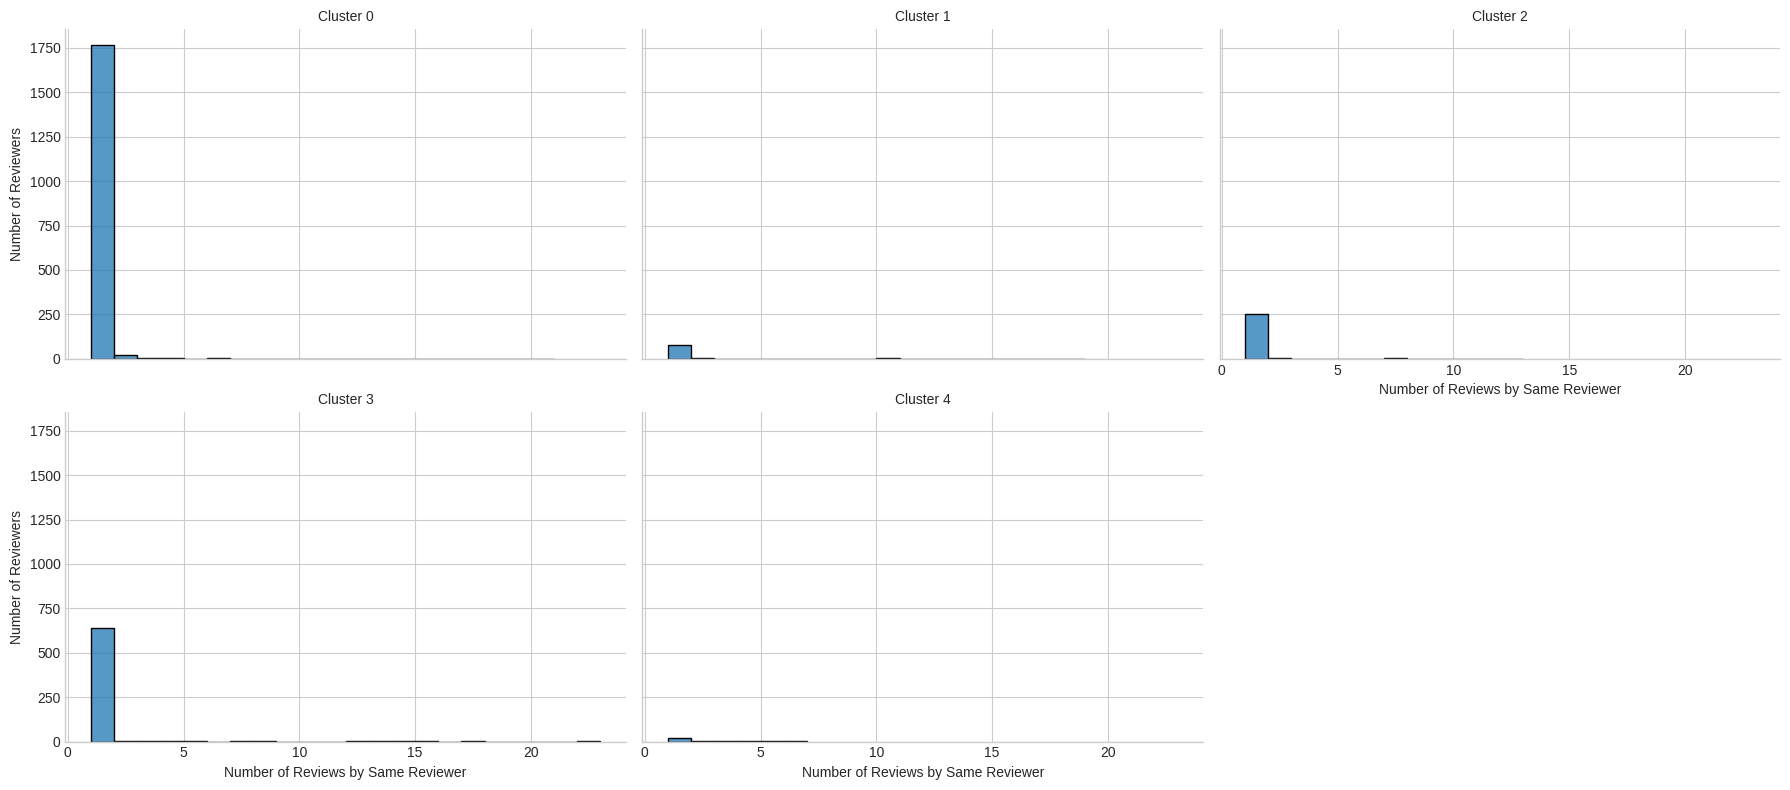

In [ ]:
# Reviewer Behavior
# Number of reviews by the same reviewer in each cluster
reviewer_counts = df_unsup.groupby(['reviewer_id', 'cluster']).size().reset_index(name='counts')
g = sns.FacetGrid(reviewer_counts, col="cluster", col_wrap=3, height=4, aspect=1.5)
g.map_dataframe(sns.histplot, x="counts", binwidth=1)
g.set_axis_labels("Number of Reviews by Same Reviewer", "Number of Reviewers")
g.set_titles("Cluster {col_name}")
plt.show()

Number of Reviews by the Same Reviewer in Each Cluster: The second set of graphs gives an idea about how many reviews a single reviewer has given in each cluster.

- Cluster 0: Most reviewers have given only a single review.
- Cluster 1: Most reviewers have given only a single review, but there's a tiny portion who've given around 5 reviews.
- Cluster 2: Most reviewers have given only a single review, with a very small fraction giving around 5 reviews.
- Cluster 3: There seems to be a split where a good portion of reviewers have given just 1 review, but a significant portion has given around 5 reviews.
- Cluster 4: Majority of the reviewers have given only a single review, with a tiny fraction giving around 5 reviews.

The clustering analysis helps in understanding patterns within the review dataset. For instance, Cluster 0 could represent a group of satisfied customers, whereas Cluster 4 may represent dissatisfied customers. You could further analyze textual content from each cluster to understand the specific reasons for positive/negative reviews. The second set of graphs can help in identifying patterns related to the frequency of reviews by individual reviewers in each cluster. This can be useful for understanding reviewer behavior and checking for any potential fake/spammy reviews. Consider using additional features or adjusting clustering parameters for possibly better or more meaningful cluster formations.